<a href="https://colab.research.google.com/github/ipietri/w266_Final_Project/blob/master/notebooks/RtGender-Notebooks/Removed_Irrelevant/RtGender_Annotations_Removed_Irrelevant_BoW_Neural_Net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## RtGender- Annotations - BoW Neural Net

In this notebook we build the baseline models for the RtGender dataset. 

Characteristics of the models:
- Neural Bag of Words architecture
- A single dense layer with dropout
- Use Glove embeddings (dim=300) without fine tuning them
- Maximum sequence length is 100




## Package imports

In [3]:
!pip install keras_tuner

     |████████████████████████████████| 98 kB 5.0 MB/s 


In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline
import seaborn as sns

from collections import Counter

import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Embedding, Input, Dense, Lambda, Dropout
from keras.models import Sequential
from tensorflow.keras.layers import TextVectorization
import tensorflow.keras.backend as K
# for hyperparameter tunning
import keras_tuner as kt
from keras_tuner import HyperModel
import keras_tuner as kt
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.sequence import pad_sequences


# import sklearn to calculate the metrics
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report


In [5]:
print(tf.__version__)

2.7.0


In [6]:
import os
os.getcwd()

'/content'

# Load
Load training, development and test datasets. See RtGender Split and Save notebook to see approach. 

In [21]:
try:
  from google.colab import drive
  drive.mount('/content/drive', force_remount=True)
  path = r'/content/drive/MyDrive/w266'
except ModuleNotFoundError:
  path = r'data'

Mounted at /content/drive


In [9]:
# annotations data
# annotations = pd.read_parquet('../../data/RtGender/annotations.parquet.gzip')


train_df = pd.read_csv('/content/drive/MyDrive/w266/annotations_train.csv')
dev_df = pd.read_csv('/content/drive/MyDrive/w266/annotations_dev.csv')

print('train_shape: ',train_df.shape)
print('dev_shape: ',dev_df.shape)

train_shape:  (10746, 9)
dev_shape:  (2303, 9)


In [11]:
# remove irrelevant annotation examples
train_df  = train_df[train_df['relevance'] != 'Irrelevant']
dev_df = dev_df[dev_df['relevance'] != 'Irrelevant']

print('updated train_shape: ',train_df.shape)
print('updated dev_shape: ',dev_df.shape)

updated train_shape:  (9482, 9)
updated dev_shape:  (2042, 9)


## Load GloVe 

In [22]:
# load pre-trained word embeddings. In this case Glove
# This is commented out to avoid downloading it again
!wget http://nlp.stanford.edu/data/glove.6B.zip -P ~/data/

# unzip the file
# commented out for the same reason above
!unzip ~/data/glove.6B.zip -d ~/data/

--2021-11-29 23:13:51--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-11-29 23:13:51--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-11-29 23:13:52--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘/root/data/glove.6B.zi

In [23]:
# path to glove file- will use the embeddings with dimension = 300
glove_file ="/root/data/glove.6B.300d.txt"

# embedding layer 
embeddings_index = {}
f = open(os.path.join(glove_file))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


# Helper functions

In [24]:
#Posts, Responses, & Annotations: op_gender (M:0, W:1)
gender_binary_mappings = {"M": 0, "W": 1}
gender_labels = ["M", "W"]

# Annotations sentiment
# group mixed and neutral 
sentiment_mappings = {'Positive': 2, 'Mixed': 1, 'Neutral': 1, 'Negative':0}
sentiment_labels = ['Positive', 'Mixed/Neutral', 'Negative']


In [25]:
def tokenize_Xtrain_and_Xdev(x_train, x_dev):
    '''Combine tokenize and split back the X_train and 
    X_dev or X_test datasets. Then create an embedding matrix.'''

    # note the length of the training index
    train_idx = len(x_train)
    #combine train and dev data and then tokenize
    texts = x_train.append(x_dev)

    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Train + Dev %s unique tokens.' % len(word_index))

    data = pad_sequences(sequences, maxlen=max_sequence_length)
    print('Shape of data tensor:', data.shape)
    
    x_train = data[:train_idx]
    x_dev = data[train_idx:]

    print('Shape of train data tensor:', x_train.shape)
    print('Shape of dev data tensor:', x_dev.shape)
    print("-"*60)
    
    # print top 5 most and least common tokens
    print("top 5 most common tokens: ", sorted(word_index, key=word_index.get, reverse=True)[-5:])
    print("top 5 least common tokens: ", sorted(word_index, key=word_index.get, reverse=True)[:5])
    print("-"*60)

    
    # build embedding matrix to use it in the model
    dimensions_emb = 300

    # zero position is zero by default in keras
    embedding_matrix = np.zeros((len(word_index) + 1, dimensions_emb)) 

    total_tokens = len(word_index) + 1
    with_embedding = []
    without_embedding = []

    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector
            with_embedding.append(word)
        else:
            without_embedding.append(word)

    print(f'Number of words with embeddings found: {len(with_embedding)}')
    print(f'Number of words with embeddings NOT found: {len(without_embedding)}')        

    
    return x_train, x_dev, embedding_matrix


In [26]:
def binary_loss_accuracy_plots(training_history):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    xrange: range in x axis
    task: string used for the title in the plot
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # summarize history for accuracy
    ax1.plot(training_history.history['binary_accuracy'])
    ax1.plot(training_history.history['val_binary_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc='upper left')

    # summarize history for loss
    ax2.plot(training_history.history['loss'])
    ax2.plot(training_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'dev'], loc='upper left')

    plt.show()
    
def multiclass_loss_accuracy_plots(training_history):
    '''
    Returns plots for loss and accuracy during the training process of a NN.
    Parameters:
    training_history: object that stores the training history of the NN (from model.fit(...))
    '''
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    
    # summarize history for accuracy
    ax1.plot(training_history.history['categorical_accuracy'])
    ax1.plot(training_history.history['val_categorical_accuracy'])
    ax1.set_title('model accuracy')
    ax1.set_ylabel('accuracy')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'dev'], loc='upper left')

    # summarize history for loss
    ax2.plot(training_history.history['loss'])
    ax2.plot(training_history.history['val_loss'])
    ax2.set_title('model loss')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'dev'], loc='upper left')

    plt.show()

In [27]:
def confusion_matrix(x_dev, original_dev_labels, class_labels):

    # identify the correct class
    max_class_idx = np.argmax(y_pred, axis = 1)
    
    # Create a confusion matrix
    cm = tf.math.confusion_matrix(original_dev_labels, max_class_idx)
    cm = cm/cm.numpy().sum(axis=1)[:, tf.newaxis]

    sns.heatmap(
        cm, annot=True,
        xticklabels=class_labels,
        yticklabels=class_labels,
        fmt='.2%', cmap='Blues')
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()
    
    # print classification report
    print(metrics.classification_report(original_dev_labels, max_class_idx))
    # print global weighted f-1 score
    f1 = metrics.f1_score(original_dev_labels, max_class_idx, pos_label=1, average='weighted')*100
    print(f"Weighted f1-score: %.2f%%" %f1)


# Annotations: Sentiment


In [31]:
X_train = train_df['response_text']
y_train = train_df['labels_4']

X_dev = dev_df['response_text']
y_dev = dev_df['labels_4']



## Preprocess & Embeddings matrix

In [32]:
# tokenize data and return embeddings matrix 
max_tokens = 10000
# consider this maximum number of words
max_sequence_length = 289
tokenizer = Tokenizer(num_words=max_tokens)

x_train, x_dev, embedding_matrix = tokenize_Xtrain_and_Xdev(X_train, X_dev)

# one-hot encodign and reshape labels
print("-"*60)

train_labels = to_categorical(np.asarray(y_train))
dev_labels = to_categorical(np.asarray(y_dev))

print('Shape of train label tensor:', train_labels.shape)
print('Shape of dev label tensor:', dev_labels.shape)

Train + Dev 18096 unique tokens.
Shape of data tensor: (11524, 289)
Shape of train data tensor: (9482, 289)
Shape of dev data tensor: (2042, 289)
------------------------------------------------------------
top 5 most common tokens:  ['and', 'you', 'i', 'to', 'the']
top 5 least common tokens:  ['grandeur', 'inadequate', 'woefully', 'lodge', 'jazzy']
------------------------------------------------------------
Number of words with embeddings found: 15510
Number of words with embeddings NOT found: 2586
------------------------------------------------------------
Shape of train label tensor: (9482, 4)
Shape of dev label tensor: (2042, 4)


## Best Model

In [36]:
def multiclass_model_builder(hp):
    model = tf.keras.Sequential()
    model.add(embedding_layer) 
    model.add(tf.keras.layers.Lambda(lambda x: K.mean(x, axis=1))) #avg

    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 10 and 100
    hp_units = hp.Int('units', min_value=10, max_value=100, step=10)
    model.add(tf.keras.layers.Dense(units=hp_units, activation='relu'))
    
    # Tune dropout layer 
    dropout = hp.Float('dropout', min_value=0.2, max_value=0.5, default=0.0, step=0.05)
    model.add(Dropout(dropout))
        
    # output layer 
    model.add(Dense(4, activation='softmax'))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss='categorical_crossentropy', 
                metrics=[tf.keras.metrics.categorical_accuracy, 'categorical_crossentropy'])

    return model

In [37]:
embedding_layer = Embedding(embedding_matrix.shape[0],
                            embedding_matrix.shape[1],
                            embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                            input_length=max_sequence_length,
                            trainable=False)

tuner = kt.Hyperband(multiclass_model_builder,
                     objective='val_categorical_accuracy',
                     max_epochs=100,
                     factor=4,
                     directory='my_dir',
                     project_name='intro_to_kt2')

tuner.search(x_train, train_labels, validation_data=(x_dev, dev_labels),
             epochs=1)

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 255 Complete [00h 03m 27s]
val_categorical_accuracy: 0.6395690441131592

Best val_categorical_accuracy So Far: 0.6395690441131592
Total elapsed time: 01h 45m 25s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 40 and the optimal learning rate for the optimizer
is 0.001.



In [38]:
# create a model off the best model
model = tuner.hypermodel.build(best_hps)
model.save('~/RtGender/annotations_sentiment_bow_neural_model_only_relevant')

# fit model 
history = model.fit(x_train, train_labels,
                    validation_data=(x_dev, dev_labels),
                    epochs=50, verbose=0)

INFO:tensorflow:Assets written to: ~/RtGender/annotations_sentiment_bow_neural_model/assets


## Metrics

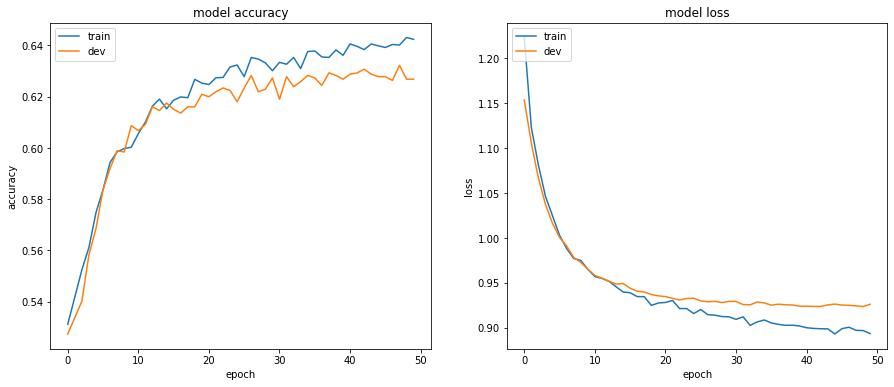

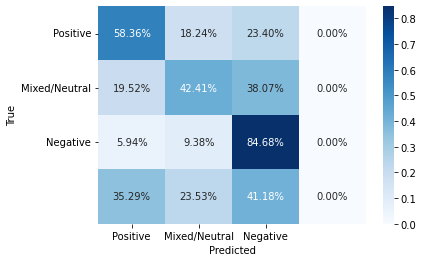

              precision    recall  f1-score   support

           0       0.46      0.58      0.52       329
           1       0.45      0.42      0.44       415
           2       0.74      0.85      0.79      1077
           3       0.00      0.00      0.00       221

    accuracy                           0.63      2042
   macro avg       0.41      0.46      0.44      2042
weighted avg       0.56      0.63      0.59      2042

Weighted f1-score: 58.77%


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [39]:
multiclass_loss_accuracy_plots(history)
y_pred = model.predict(x_dev) #predict
confusion_matrix(x_dev, y_dev, sentiment_labels)